# Deriving Doc Similarity

In [85]:
import re
import numpy as np
import pandas as pd
# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
import string 

from sklearn.manifold import TSNE

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [86]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/katinka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [315]:
# Convert to list
df = pd.read_csv('kaggle_datasets/medium_post_titles.csv')

In [316]:
df.head(3)

category                                              title  \
0          work  "21 Conversations" - A fun (and easy) game for...   
1  spirituality                       "Biblical Porn" at Mars Hill   
2       lgbtqia                  "CISGENDER?! Is That A Disease?!"   

                                            subtitle  subtitle_truncated_flag  
0  A (new?) Icebreaker game to get your team to s...                    False  
1  Author and UW lecturer Jessica Johnson talks a...                    False  
2  Or, a primer in gender vocabulary for the curi...                    False

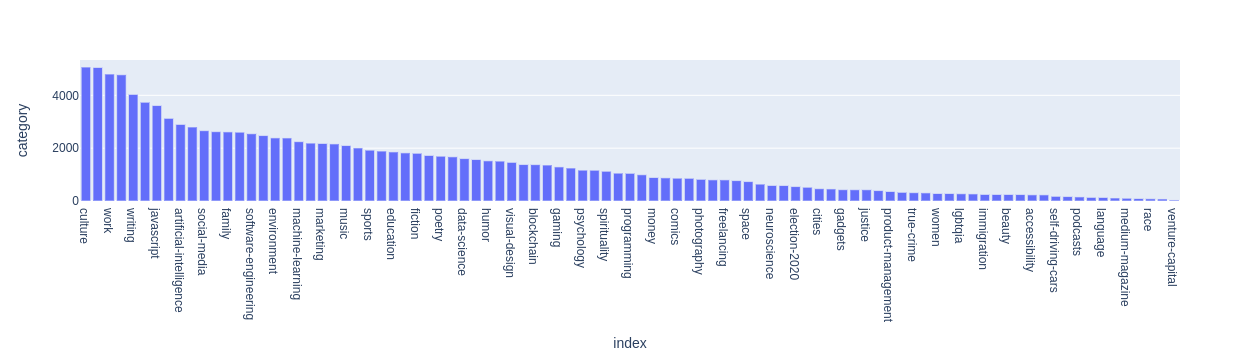

In [317]:
fig = px.bar(df['category'].value_counts().reset_index(), x='index', y='category')
fig.show()

In [324]:
cat_df = df['category'].value_counts().reset_index().head(5)
cat_list = cat_df['index'].tolist()

df = df[df['category'].isin(cat_list)]

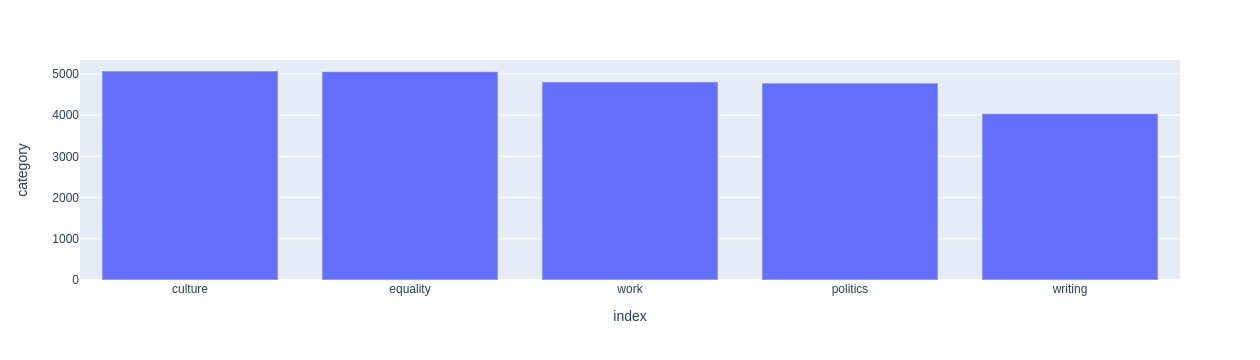

In [325]:
fig = px.bar(cat_df, x='index', y='category')
fig.show()

In [326]:
len(df)

23741

In [327]:
df['category'].nunique()

5

In [328]:
def clean_punc(row):
    """
    Remove punctuations.
    """
    # Remove puntuations
    text = ''.join([c for c in str(row) if c not in string.punctuation])
    # Define the pattern 
    pat = r'[^a-zA-z0-9.,!?/:;\"\'|\r\s]\n' 
    word = re.sub(pat, '', text)
    # Remove new line
    cleaned = re.sub('\n','',word)
    return str(cleaned)

In [384]:
# Create list of titles
data = df['title'].tolist()

# Remove Special characters
data = [clean_punc(item) for item in data]

data[:5]

['21 Conversations  A fun and easy game for teams to get to know each other',
 'Call me Nat Love Black Cowboys and the Frontiers of American Freedom',
 'Diss vs Piss The Blue Wave and Yellow Trickle in Californias Central Valley',
 'Happily Ever After Fairy Tales for Every Child or the Underrated HBO Show That Tried to Tackle…',
 'Killing Eve and Women Who Love Murder']

In [330]:
# Tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data[:2]

[TaggedDocument(words=['21', 'conversations', 'a', 'fun', 'and', 'easy', 'game', 'for', 'teams', 'to', 'get', 'to', 'know', 'each', 'other'], tags=['0']),
 TaggedDocument(words=['call', 'me', 'nat', 'love', 'black', 'cowboys', 'and', 'the', 'frontiers', 'of', 'american', 'freedom'], tags=['1'])]

In [331]:
len(data)

23741

In [332]:
# Train doc2vec model
vec_size = 100
alpha = 0.025
nr_epochs = 100

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                workers=5,
                dm=1)
  
model.build_vocab(tagged_data)


model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=nr_epochs)

model.save("d2v_sm.model")
print("Model Saved")

Model Saved


## Clustering based on doc vectors

In [333]:
model = Doc2Vec.load("d2v_sm.model")

In [334]:
data_vects = model.dv.vectors

In [373]:
tsne = TSNE(n_components=2, 
            verbose=2,
            learning_rate=500,
            perplexity=30, 
            n_iter=2000, 
            init='pca')

tsne_vectors = tsne.fit_transform(data_vects)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23741 samples in 0.003s...
[t-SNE] Computed neighbors for 23741 samples in 16.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23741
[t-SNE] Computed conditional probabilities for sample 2000 / 23741
[t-SNE] Computed conditional probabilities for sample 3000 / 23741
[t-SNE] Computed conditional probabilities for sample 4000 / 23741
[t-SNE] Computed conditional probabilities for sample 5000 / 23741
[t-SNE] Computed conditional probabilities for sample 6000 / 23741
[t-SNE] Computed conditional probabilities for sample 7000 / 23741
[t-SNE] Computed conditional probabilities for sample 8000 / 23741
[t-SNE] Computed conditional probabilities for sample 9000 / 23741
[t-SNE] Computed conditional probabilities for sample 10000 / 23741
[t-SNE] Computed conditional probabilities for sample 11000 / 23741
[t-SNE] Computed conditional probabilities for sample 12000 / 23741
[t-SNE] Computed conditional probabilities for sa

In [374]:
tsne_df = pd.DataFrame(
    tsne_vectors,
    index=df['title'].tolist(),
    columns=['x_coord', 'y_coord']
    )

tsne_df['category'] = df['category'].tolist()

tsne_df = tsne_df.reset_index()

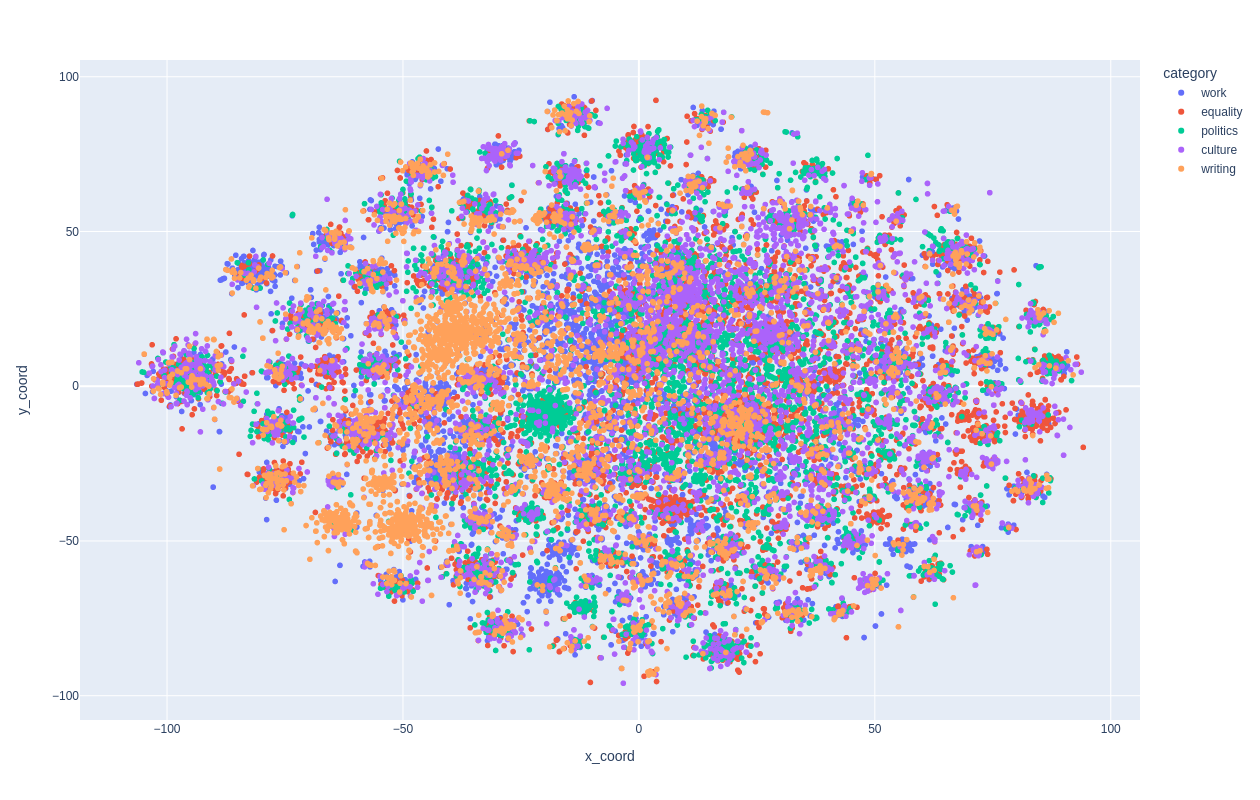

In [375]:
# x and y given as DataFrame columns
fig = px.scatter(tsne_df, 
                 x="x_coord", 
                 y="y_coord",
                 hover_data=['index', 'category'],
                 color='category'
                )
fig.update_layout(width=1000,
                  height=800)
fig.show()